/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0365 - val_loss: 0.0126
Epoch 2/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0098 - val_loss: 0.0065
Epoch 3/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0051 - val_loss: 0.0035
Epoch 4/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0032 - val_loss: 0.0057
Epoch 5/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 6/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 7/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 8/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0014 - val_loss: 0.0085
Epoch 9/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 10/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 11/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 12/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/s

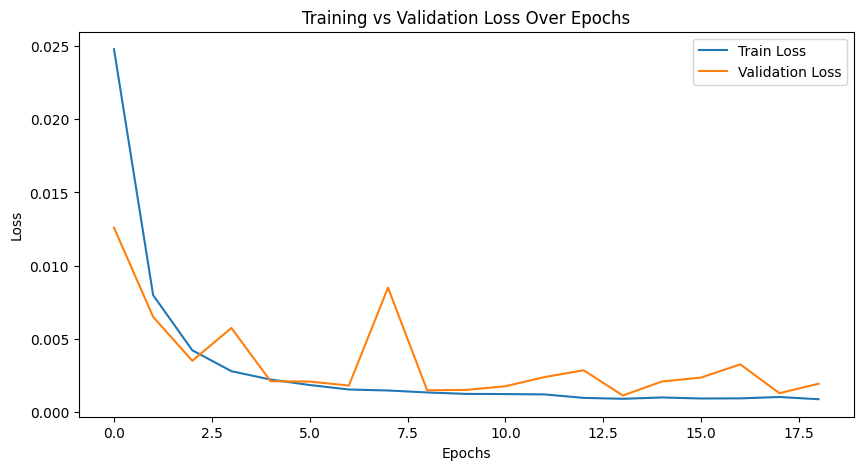

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step

Evaluation Metrics:
MSE: 101.3823
RMSE: 10.0689
MAE: 8.9989
R² Score: -0.1384

Recent 5 Days (Actual vs Predicted):
Day 95 => Actual: 229.57, Predicted: 221.01
Day 96 => Actual: 228.20, Predicted: 220.23
Day 97 => Actual: 231.20, Predicted: 220.35
Day 98 => Actual: 236.91, Predicted: 221.50
Day 99 => Actual: 241.25, Predicted: 223.86


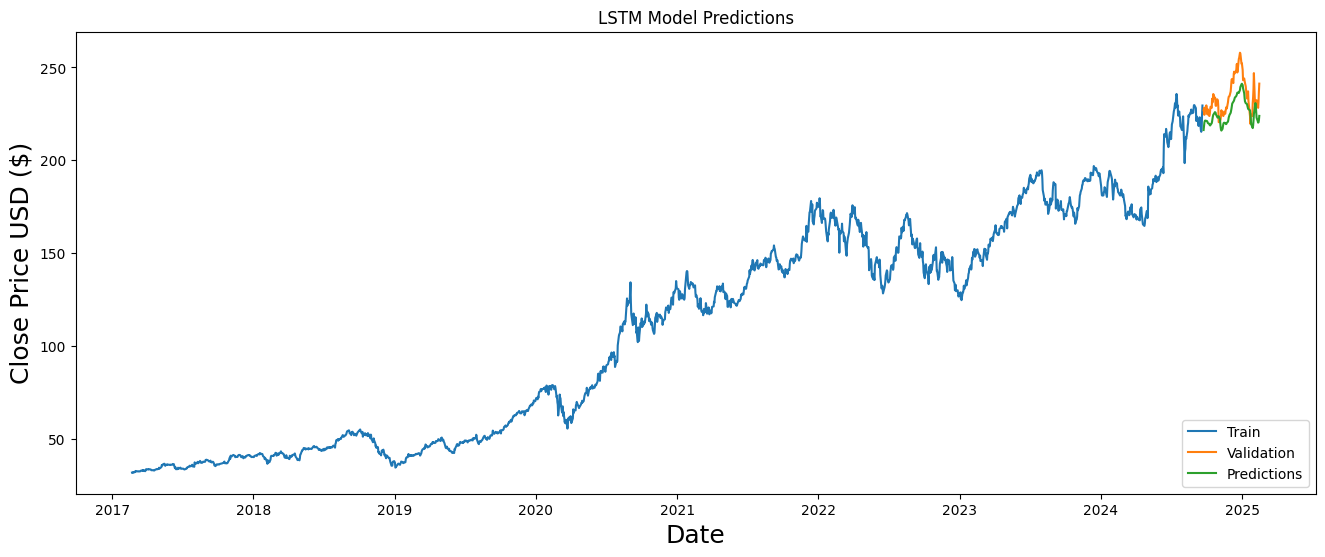

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def modelBuildingLSTM():
    # Load the stock data
    df = pd.read_pickle('stock_data.pkl')
    df = df[df['company_name'] == 'AAPL']  # Select AAPL stock only
    df.set_index('Date', inplace=True)

    # Keep only the 'Close' price
    df = df[['Close']]

    # Feature Scaling: Use MinMaxScaler for 'Close' price
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df)

    # Define training data length (95% of dataset)
    data_len = int(np.ceil(len(scaled_data) * 0.95))
    train_data = scaled_data[:data_len]

    # Prepare training data for LSTM
    x_train, y_train = [], []
    for i in range(60, len(train_data)):
        x_train.append(train_data[i - 60:i, 0])
        y_train.append(train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Build Optimized LSTM Model
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(0.1))  # Reduced dropout
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.1))  # Reduced dropout
    model.add(Dense(25, kernel_regularizer=l2(0.001)))  # L2 regularization
    model.add(Dense(1, kernel_regularizer=l2(0.001)))   # L2 regularization

    model.compile(optimizer='adam', loss='mean_squared_error')

    # Early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train LSTM Model with batch size = 8
    history = model.fit(
        x_train, y_train,
        batch_size=8,
        epochs=50,
        validation_split=0.1,
        verbose=1,
        callbacks=[early_stop]
    )

    # Plot Training vs Validation Loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss Over Epochs')
    plt.legend()
    plt.show()

    # Prepare test data
    test_data = scaled_data[data_len - 60:]
    index_value = df.index[data_len]

    x_test = []
    y_test = df.loc[index_value:, :].copy()  # Use .loc for test slicing

    for i in range(60, len(test_data)):
        x_test.append(test_data[i - 60:i, 0])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # Make predictions
    predictions = model.predict(x_test)

    # Inverse transform predictions
    predictions = scaler.inverse_transform(predictions)

    # Inverse transform actual values for correct evaluation
    y_test_values = test_data[60:, 0]
    actual_prices = scaler.inverse_transform(y_test_values.reshape(-1, 1)).flatten()

    # Compute MSE, RMSE, MAE, and R²
    mse = mean_squared_error(actual_prices, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_prices, predictions)
    r2 = r2_score(actual_prices, predictions)

    print(f'\nEvaluation Metrics:')
    print(f'MSE: {mse:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'R² Score: {r2:.4f}')

    # Print the most recent 5 days (Actual vs. Predicted)
    recent_days = 5
    print(f'\nRecent {recent_days} Days (Actual vs Predicted):')
    for i in range(-recent_days, 0):
        day_index = len(actual_prices) + i
        print(f"Day {day_index} => Actual: {actual_prices[day_index]:.2f}, Predicted: {predictions[day_index][0]:.2f}")

    # Prepare data for visualization
    train = df[:data_len]
    valid = df.loc[index_value:, :].copy()
    valid['Predictions'] = predictions

    # Plot results
    plt.figure(figsize=(16, 6))
    plt.title('LSTM Model Predictions')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(train['Close'], label='Train')
    plt.plot(valid['Close'], label='Validation')
    plt.plot(valid['Predictions'], label='Predictions')
    plt.legend(['Train', 'Validation', 'Predictions'], loc='lower right')
    plt.show()

if __name__ == "__main__":
    modelBuildingLSTM()
